# Projet

In [55]:
!pip3 install scikit-learn==0.22.2

In [56]:
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from time import time

from numpy.linalg import eig, inv
import warnings
warnings.filterwarnings("ignore")

In [57]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

Classes :
|nb|name|
|--|--|
|0 |T-shirt/top|
|1 |Trouser|
|2 |Pullover|
|3 |Dress|
|4 |Coat|
|5 |Sandal|
|6 |Shirt|
|7 |Sneaker|
|8 |Bag|
|9 |Ankle boot|

In [58]:
classes = { 0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
def isA(nb: int):
  return classes[nb]

Class: Ankle boot


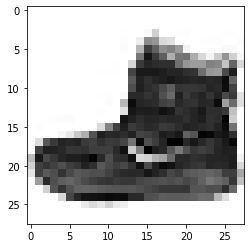

In [59]:
from matplotlib import cm
plt.imshow(X_train[0], cmap=cm.Greys)
print("Class:", isA(Y_train[0]))

On voit que l'élément 0 est de la classe `Ankle boot`.

## 1. Tests des différents algorithmes de classification

In [60]:
# Re shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

### K-nn

In [61]:
from sklearn.neighbors import KNeighborsClassifier

def executeKnn(X_train, Y_train, X_test, Y_test, k=5):
  # Create K-nn classifier
  knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  t = time()
  # Train the classifier
  knn.fit(X_train, Y_train)
  print("training time: ", time() - t)

  # Test the classifier
  Y_pred = knn.predict(X_test)

  print("k = {:d} : {:.2%}".format(k, accuracy_score(Y_test, Y_pred)))

On se limite à un échantillon du dataset car le K-nn était trop lent à s'exécuter

In [62]:
nbTrain = X_train.shape[0]
print("Nb train", nbTrain)
nbTest = X_test.shape[0]
print("Nb test", nbTest)

divFactor = 8

nbTrainSample = round(nbTrain / divFactor)
print("Nb train sample", nbTrainSample)
nbTestSample = round(nbTest / divFactor)
print("Nb test sample", nbTestSample)

X_train_sample = X_train[:nbTrainSample]
Y_train_sample = Y_train[:nbTrainSample]
X_test_sample = X_test[:nbTestSample]
Y_test_sample = Y_test[:nbTestSample]

Nb train 60000
Nb test 10000
Nb train sample 7500
Nb test sample 1250


In [63]:
for k in range (1, 6):
  executeKnn(X_train_sample, Y_train_sample, X_test_sample, Y_test_sample, k)

training time:  0.6932754516601562
k = 1 : 79.28%
training time:  0.5775711536407471
k = 2 : 80.64%
training time:  0.5718162059783936
k = 3 : 80.80%
training time:  0.5930962562561035
k = 4 : 80.88%
training time:  0.6118450164794922
k = 5 : 82.24%


### Classifieur bayésien

In [64]:
from sklearn.naive_bayes import GaussianNB

def executeBayes(X_train, Y_train, X_test, Y_test):
  # Create ML classifier
  knn = GaussianNB()
  t = time()
  # Train the classifier
  knn.fit(X_train, Y_train)
  print("training time: ", time() - t)

  # Test the classifier
  Y_pred = knn.predict(X_test)

  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

In [65]:
executeBayes(X_train, Y_train, X_test, Y_test)

training time:  0.7577176094055176
58.56%


### Arbre de décision

In [66]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

def displayTree(dt, features_cols, class_names):
  dot_data = StringIO()
  export_graphviz(dt, out_file=dot_data,
                  filled=True, rounded=True,
                  special_characters=True,feature_names = features_cols,class_names=class_names)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('fashion.png')
  Image(graph.create_png())

In [67]:
from sklearn.tree import DecisionTreeClassifier

def executeDecisionTree(X_train, Y_train, X_test, Y_test, display=False):
  # Create Decision Tree classifier
  dt = DecisionTreeClassifier(criterion='entropy')
  t = time()
  # Train the classifier
  dt.fit(X_train, Y_train)
  print("training time: ", time() - t)

  if display:
    features_cols = [str(k) for k in range(X_train.shape[1])]
    class_names = [str(k) for k in classes.keys()]
    displayTree(dt, features_cols, class_names)

  # Test the classifier
  Y_pred = dt.predict(X_test)

  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

In [68]:
executeDecisionTree(X_train, Y_train, X_test, Y_test)

training time:  37.30102491378784
80.11%


On a trop de données donc l'arbre de décision est trop grand pour être affiché.

On cherche les meilleurs paramètres :

In [69]:
if False:
  criterion = ['gini', 'entropy']
  max_depth = [3, 5, 10]
  min_samples_leaf = [1, 2, 5]
  min_samples_split = [2, 3, 4]

  best_params = None
  best_score = 0
  for c in criterion:
      for depth in max_depth:
          for l in min_samples_leaf:
              for s in min_samples_split:
                  dt = DecisionTreeClassifier(criterion=c, max_depth=depth, min_samples_leaf=l, min_samples_split=s)
                  dt.fit(X_train, Y_train)
                  y_pred = dt.predict(X_test)
                  scores = accuracy_score(Y_test, y_pred)
                  if best_score==0 or scores > best_score:
                      best_score = scores
                      best_params = [c, depth, l, s]

  print('Best Accuracy: ','{:2.2%}'.format(best_score))
  print('Parameters: ', best_params)

### Forêts aléatoires

In [70]:
from sklearn.ensemble import RandomForestClassifier

def executeRandomForest(X_train, Y_train, X_test, Y_test):
  # Create Random Forest classifier
  rf = RandomForestClassifier()
  t = time()
  # Train the classifier
  rf.fit(X_train, Y_train)
  print("training time: ", time() - t)

  # Test the classifier
  Y_pred = rf.predict(X_test)

  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

In [71]:
executeRandomForest(X_train, Y_train, X_test, Y_test)

training time:  94.64232468605042
87.65%


On cherche les meilleurs paramètres:

In [72]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 5, 10, None], 'min_samples_split': [1, 2, 5], 'min_samples_leaf': [2, 3, 4], 'bootstrap': [True, False]}


In [73]:
if False:
  rf = RandomForestClassifier()
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                                cv = 3, verbose=2, random_state=42, n_jobs = -1)
  t = time()

  rf_random.fit(X_train_sample, Y_train_sample)
  print("training time: ", time() - t)

  Y_pred = rf.predict(X_test_sample)
  print("{:.2%}".format(accuracy_score(Y_test_sample, Y_pred)))
  rf_random.best_params_

On voit que l'accuracy de K-NN, Random forest et Decision tree tourne autour de 80%. Donc ces algorithmes sont efficaces par rapport à Bayes qui n'a qu'une accuracy à 60%.

## 2. Comparaison des techniques de réduction de dimension

### Evaluation de l'impact de la réduction avec `ACP`

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def doPCA(X, nbComponents=None, display=False):
  # StandardScaler removes the mean and scales to the unit variance
  scaler = StandardScaler()
  z = scaler.fit_transform(X)

  # Do the PCA reduction
  acp = PCA(nbComponents)
  X_acp = acp.fit_transform(z)

  print(acp.n_components_)
  print(acp.explained_variance_ratio_.sum())

  if display:
    plt.grid()
    plt.plot(np.arange(1, acp.n_components_+1),acp.explained_variance_ratio_)
    plt.ylabel("Eigen values")
    plt.xlabel("Factor number")
    plt.xlim([0, 20])
    plt.show()

  return X_acp

In [75]:
# Merge data
X = np.concatenate([X_train, X_test])
Y = np.concatenate([Y_train, Y_test])
print(X.shape)
X

(70000, 784)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

784
1.0000000000000002


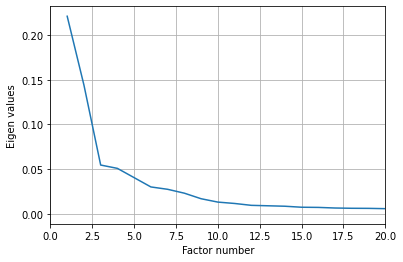

In [76]:
# Elbow criterion
X_acp = doPCA(X, None, True)

In [77]:
X_acp = doPCA(X, 3)
X_train_acp = X_acp[:nbTrain]
X_test_acp = X_acp[nbTrain:]

3
0.4195832834263943


Text(0, 0.5, 'ACP2')

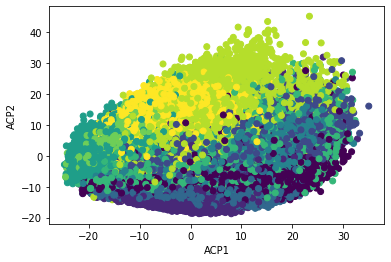

In [78]:
plt.scatter(X_acp[:, 0], X_acp[:, 1], c=Y)
plt.xlabel('ACP1')
plt.ylabel('ACP2')

In [79]:
# Execution of K-nn on reduced data
for k in range (1, 6):
  executeKnn(X_train_acp, Y_train, X_test_acp, Y_test, k)

training time:  0.05884981155395508
k = 1 : 56.89%
training time:  0.0395817756652832
k = 2 : 56.98%
training time:  0.04141664505004883
k = 3 : 60.10%
training time:  0.03846144676208496
k = 4 : 60.98%
training time:  0.0426325798034668
k = 5 : 62.09%


Comparaison avec l'exécution de K-nn sans réduction : on voit que la réduction ne rend pas la classification plus efficace néanmoins, le temps d'exécution est beaucoup plus court avec la réduction que sans. De plus, l’accuracy passe de 82% à 62% donc la réduction ne rend pas plus faisable la classification des données.

In [80]:
# Execution of Bayes on reduced data
executeBayes(X_train_acp, Y_train, X_test_acp, Y_test)

training time:  0.019935131072998047
54.83%


Comparaison avec l'exécution de Bayes sans réduction : on voit que la réduction ne rend pas la classification plus efficace néanmoins, le temps d'exécution est beaucoup plus court avec la réduction que sans.

In [81]:
# Execution of Decision tree on reduced data
executeDecisionTree(X_train_acp, Y_train, X_test_acp, Y_test)

training time:  0.7981045246124268
55.68%


Comparaison avec l'exécution de l'Arbre de décision sans réduction : on voit que même si le temps d’exécution est beaucoup plus court avec la réduction, l’accuracy passe de 80% à 55% ! Ce qui rend la faisabilité de la classification très difficile. Il vaut mieux ne pas réduire les données si l’on utilise cet algorithme.

In [82]:
# Execution of Random forest on reduced data
executeRandomForest(X_train_acp, Y_train, X_test_acp, Y_test)

training time:  10.613870859146118
63.59%


Comparaison avec l'exécution de la Forêt aléatoire sans réduction : on voit que même si le temps d’exécution est beaucoup plus court avec la réduction, l’accuracy passe de 87% à 63% ! Ce qui rend la faisabilité de la classification très difficile. Il vaut mieux ne pas réduire les données si l’on utilise cet algorithme.

### Evaluation de l'impact de la réduction avec `LDA`

In [83]:
# Do the LDA reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def doLDA(X, Y):
  lda = LinearDiscriminantAnalysis()
  X_lda = lda.fit_transform(X, Y)
  print(lda.explained_variance_ratio_)
  return X_lda

In [84]:
X_lda = doLDA(X, Y)
X_train_lda = X_lda[:nbTrain]
X_test_lda = X_lda[nbTrain:]

[0.44775652 0.21875177 0.09237004 0.07396008 0.06062643 0.04305586
 0.03801965 0.01584194 0.00961772]


Text(0, 0.5, 'LDA2')

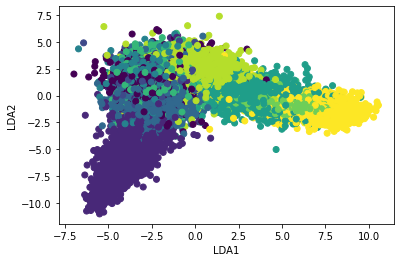

In [85]:
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=Y)
plt.xlabel('LDA1')
plt.ylabel('LDA2')

In [86]:
# Execution of K-nn on reduced data
for k in range (1, 6):
  executeKnn(X_train_lda, Y_train, X_test_lda, Y_test, k)

training time:  0.15750336647033691
k = 1 : 79.35%
training time:  0.10144448280334473
k = 2 : 80.25%
training time:  0.09493803977966309
k = 3 : 81.77%
training time:  0.09476423263549805
k = 4 : 82.59%
training time:  0.10509753227233887
k = 5 : 82.93%


Comparaison avec l'exécution de K-nn sans réduction : on constate un gain de temps d'exécution significatif par rapport au K-nn sans réduction tout en conservant des résultats similaires.

In [87]:
# Execution of Bayes on reduced data
executeBayes(X_train_lda, Y_train, X_test_lda, Y_test)

training time:  0.021036386489868164
81.72%


Comparaison avec l'exécution de Bayes sans réduction : ici, les performances sont grandement supérieures au Classifieur Bayésien sans réduction, on passe de 55% à 82% tout en minimisant le temps d’exécution.

In [88]:
# Execution of Decision tree on reduced data
executeDecisionTree(X_train_lda, Y_train, X_test_lda, Y_test)

training time:  1.8988239765167236
77.74%


Comparaison avec l'exécution de l'Arbre de décision sans réduction : pour l’arbre de décision on observe une légère baisse de la performance. On a tout de même un gain en temps de traitement très important.

In [89]:
# Execution of Random forest on reduced data
executeRandomForest(X_train_lda, Y_train, X_test_lda, Y_test)

training time:  29.20334267616272
84.13%


Comparaison avec l'exécution de la Forêt aléatoire sans réduction : pour finir, les résultats concernant la forêt aléatoire sont similaires à ceux de l’arbre de décision, le gain de temps est considérable mais il y a une légère diminution de la performance de l’ordre de 2%.

### Conclusion:
Globalement, avec l’ACP, le temps d’exécution est drastiquement réduit mais la classification devient très difficile car l’accuracy baisse de manière significative donc cette réduction n’est pas efficace si l’on veut classer nos données. Alors qu’avec LDA, on a également le temps d’exécution réduit mais la classification est encore plus précise pour Bayes ou est plus ou moins bonne avec les autres algorithmes.
En termes d’exécution, les réductions sont toutes les deux efficaces dans la limite où l’on peut observer un temps de traitement grandement diminué (surtout en ce qui concerne les arbres de décisions et les forêts aléatoires).
En revanche on remarque une diminution globale des performances en ce qui concerne l’ACP tandis qu’avec la LDA les résultats sont constants ou diminuent très légèrement.
Donc il vaut mieux choisir de réduire avec LDA plutôt qu’avec ACP pour classer nos données efficacement.